In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

results_path = Path("/Users/Matey/project/fact8/benchmarks/results/")
mcts_path = Path("/Users/Matey/project/fact8/tgnnexplainer/xgraph/saved_mcts_results/")

explainers = ["xtg", "attn", "pbone", "pg"]
labels = {k: v for k, v in zip(explainers, ["TGNN-X", "ATTN", "PBONE", "PG"])}

In [151]:
## Their data
df_tgat_theirs = {
    ("Wikipedia", "Best FID"): {
        "ATTN": 0.891,
        "PBONE": 0.027,
        "PG": 1.354,
        "TGNN-X": 1.836,
    },
    ("Wikipedia", "AUFSC"): {
        "ATTN": 0.564,
        "PBONE": -2.227,
        "PG": 0.564,
        "TGNN-X": 1.477,
    },
    ("Reddit", "Best FID"): {
        "ATTN": 0.658,
        "PBONE": 0.167,
        "PG": 0.804,
        "TGNN-X": 1.518,
    },
    ("Reddit", "AUFSC"): {
        "ATTN": -0.654,
        "PBONE": -2.492,
        "PG": -0.369,
        "TGNN-X": 1.076,
    },
    ("Simulate V1", "Best FID"): {
        "ATTN": 0.555,
        "PBONE": 0.044,
        "PG": 0.555,
        "TGNN-X": 0.78,
    },
    ("Simulate V1", "AUFSC"): {
        "ATTN": -0.081,
        "PBONE": -2.882,
        "PG": 0.39,
        "TGNN-X": 0.666,
    },
    ("Simulate V2", "Best FID"): {
        "ATTN": 0.605,
        "PBONE": 0.096,
        "PG": 1.329,
        "TGNN-X": 1.63,
    },
    ("Simulate V2", "AUFSC"): {
        "ATTN": 0.291,
        "PBONE": -4.771,
        "PG": -0.926,
        "TGNN-X": 1.331,
    },
}

df_tgn_theirs = {
    ("Wikipedia", "Best FID"): {
        "ATTN": 0.479,
        "PBONE": 0.296,
        "PG": 0.464,
        "TGNN-X": 0.866,
    },
    ("Wikipedia", "AUFSC"): {
        "ATTN": 0.231,
        "PBONE": -0.601,
        "PG": -0.231,
        "TGNN-X": 0.59,
    },
    ("Reddit", "Best FID"): {
        "ATTN": 0.575,
        "PBONE": 0.34,
        "PG": 0.679,
        "TGNN-X": 1.362,
    },
    ("Reddit", "AUFSC"): {"ATTN": 0.289, "PBONE": -0.256, "PG": 0.02, "TGNN-X": 1.113},
    ("Simulate V1", "Best FID"): {
        "ATTN": 2.178,
        "PBONE": 0.001,
        "PG": 2.006,
        "TGNN-X": 2.708,
    },
    ("Simulate V1", "AUFSC"): {
        "ATTN": 1.624,
        "PBONE": -3.311,
        "PG": 0.626,
        "TGNN-X": 2.281,
    },
    ("Simulate V2", "Best FID"): {
        "ATTN": 0.988,
        "PBONE": 0.32,
        "PG": 1.012,
        "TGNN-X": 4.356,
    },
    ("Simulate V2", "AUFSC"): {
        "ATTN": -1.338,
        "PBONE": -5.413,
        "PG": -1.338,
        "TGNN-X": 3.224,
    },
}

df_tgat_theirs = pd.DataFrame.from_dict(df_tgat_theirs, orient="columns")
df_tgn_theirs = pd.DataFrame.from_dict(df_tgn_theirs, orient="columns")
# df_tgat_theirs

## TGAT
### Wikipedia

Best Fid: {'xtg': 1.4116824127268046, 'attn': 0.8115232161860914, 'pbone': 1.2597488984894007, 'pg': 0.6847479770611972}
AUFSC: {'xtg': 0.913682348204963, 'attn': 0.5135449832312763, 'pbone': 0.8691429948334582, 'pg': -0.37464903415529993}
xtg	 FID: 0.7718711843846278 	 AUC: 0.913682348204963
attn	 FID: 0.4633937401310318 	 AUC: 0.5135449832312763
pbone	 FID: 0.8280495267829725 	 AUC: 0.8691429948334582
pg	 FID: -0.43719394557967417 	 AUC: -0.37464903415529993


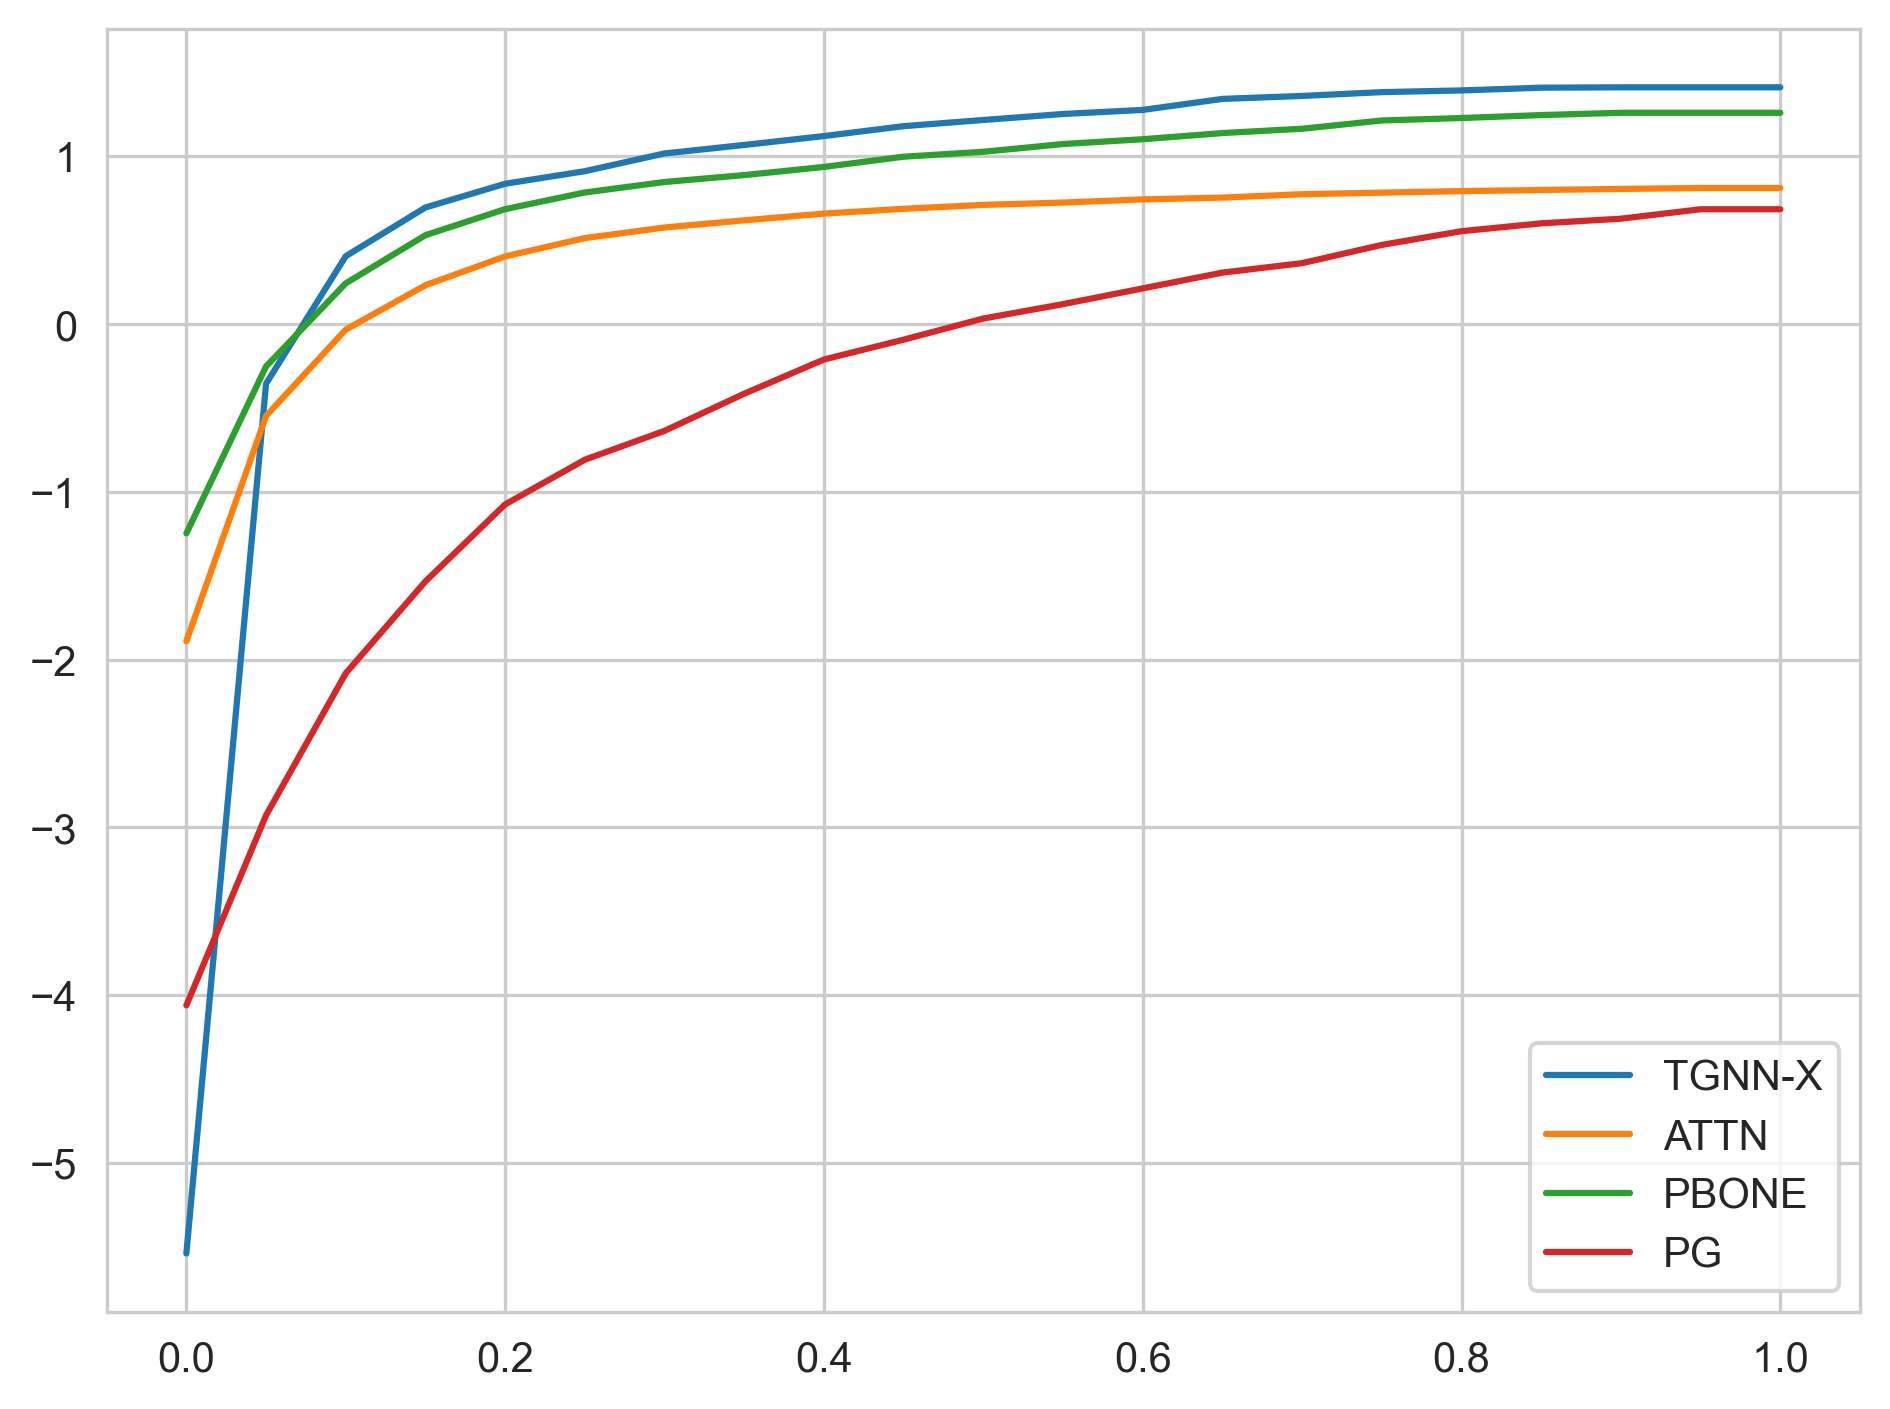

In [17]:
tgat_wikipedia_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_wikipedia_subgraphx_tg_110314_to_155614_eval_pg_true_pg_positive.csv",
            "tgat_wikipedia_attn_explainer_tg_110314_to_155614_eval.csv",
            "tgat_wikipedia_pbone_explainer_tg_110314_to_155614_eval.csv",
            "tgat_wikipedia_pg_explainer_tg_110314_to_155614_eval.csv",
        ],
    )
}

tgat_wikipedia_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgat_wikipedia_files.items()
}

tgat_wikipedia_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgat_wikipedia_tabs.items()
}
tgat_wikipedia_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index) for k, tab in tgat_wikipedia_tabs.items()
}

print("Best Fid:", tgat_wikipedia_best_fids)
print("AUFSC:", tgat_wikipedia_aufsc)

for k, tab in tgat_wikipedia_tabs.items():
    print(
        f"{k}\t FID: {tab['fid_inv_best'].mean()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
    )
    plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgat_wikipedia.png")

## Reddit

Best Fid: {'xtg': 1.188740246668458, 'attn': 0.46591258417069914, 'pbone': 1.2121049303114415, 'pg': 0.5481336815953255}
AUFSC: {'xtg': 0.4211314124386758, 'attn': -0.9362572968028485, 'pbone': 0.8172783054485916, 'pg': -0.8289851863332094}
xtg	 FID: 1.188740246668458 	 AUC: 0.4211314124386758
attn	 FID: 0.46591258417069914 	 AUC: -0.9362572968028485
pbone	 FID: 1.2121049303114415 	 AUC: 0.8172783054485916
pg	 FID: 0.5481336815953255 	 AUC: -0.8289851863332094


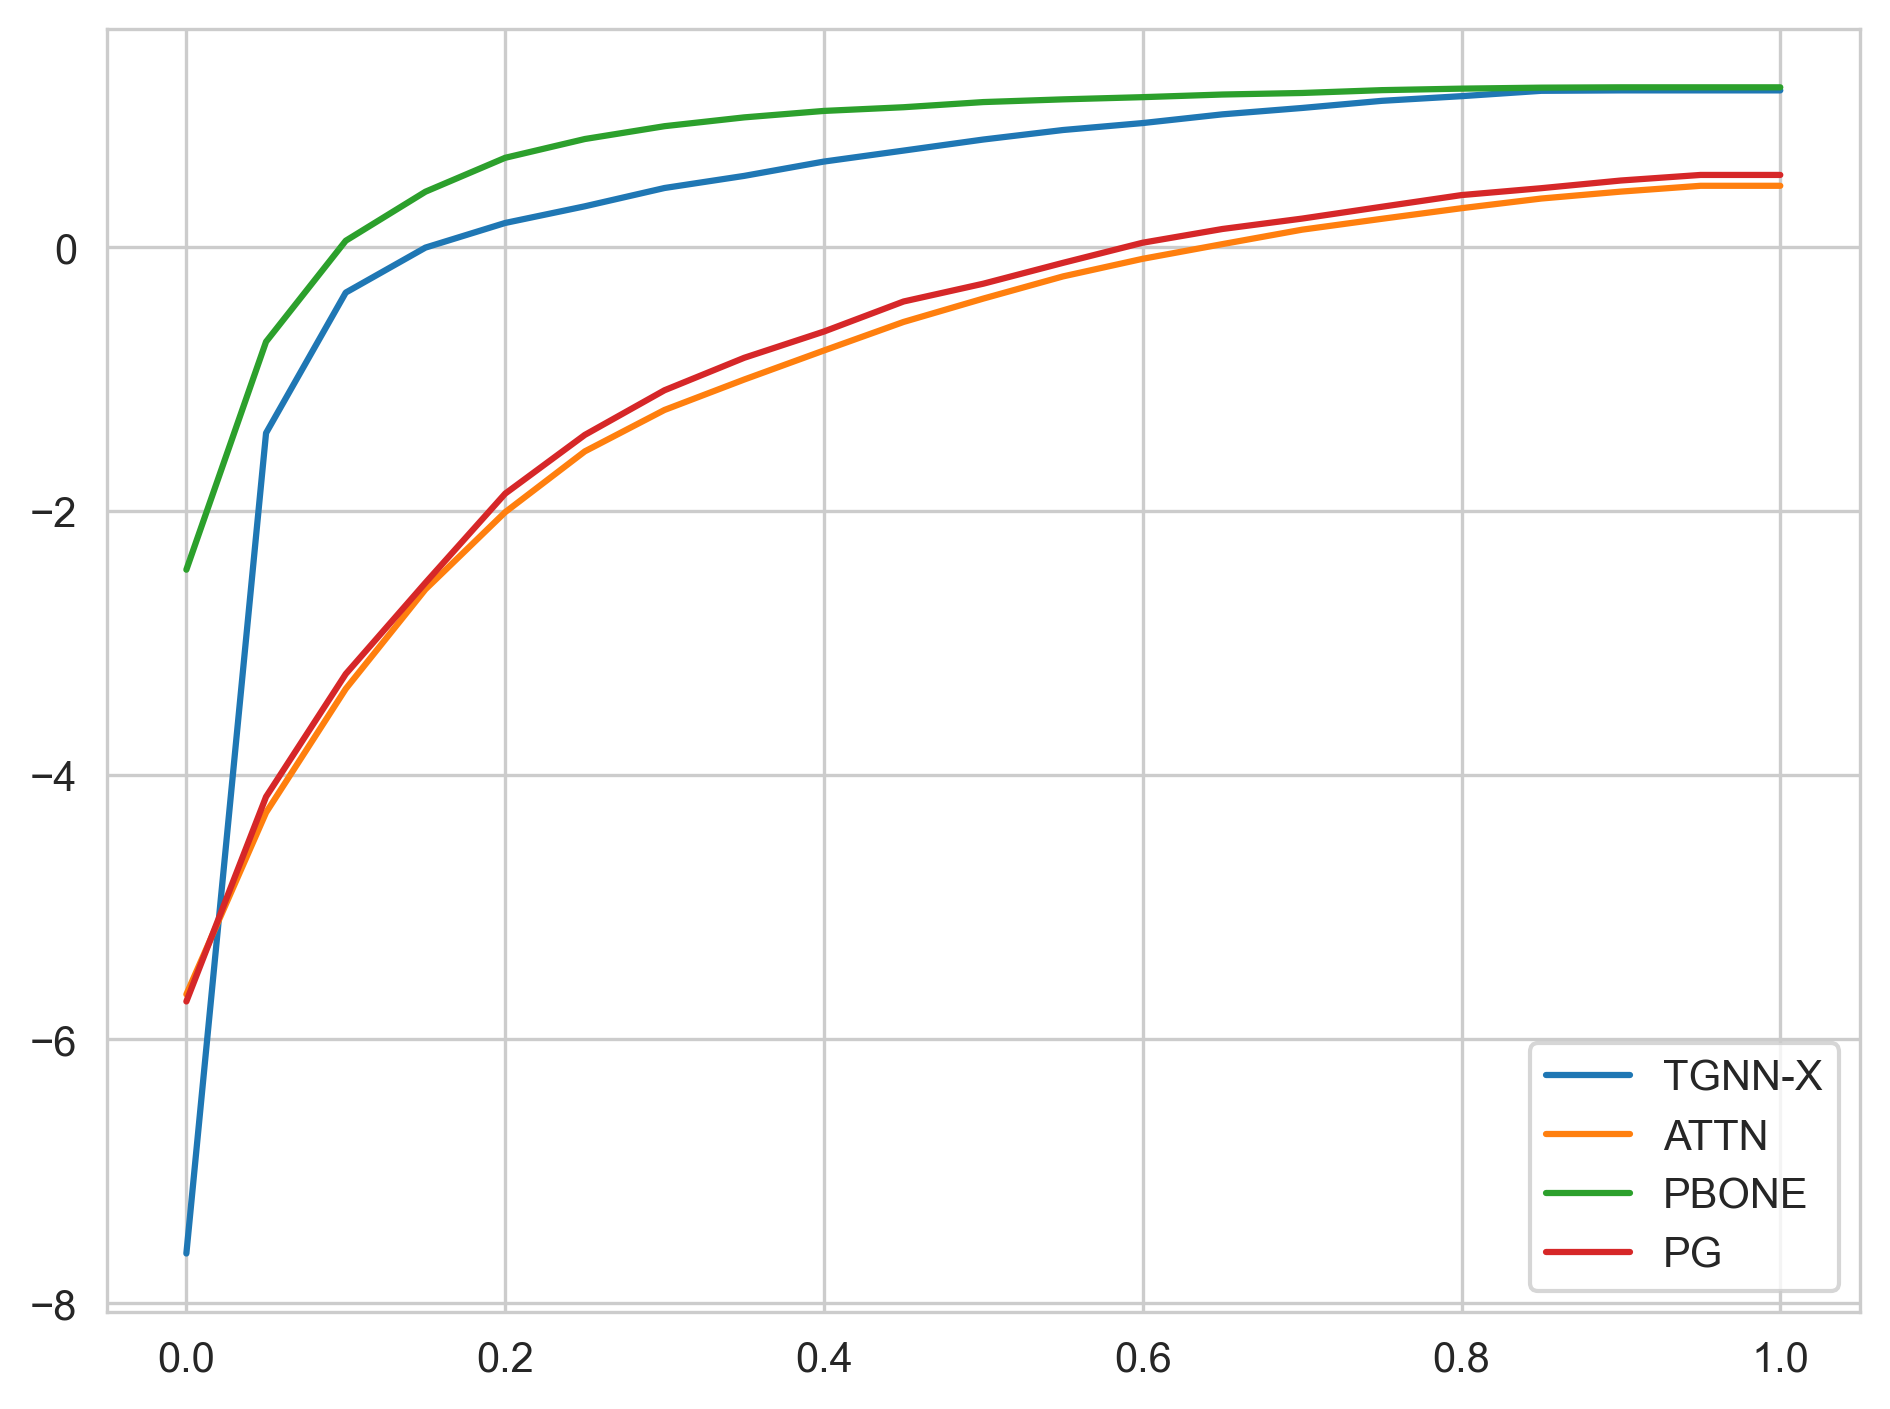

In [153]:
tgat_reddit_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_reddit_subgraphx_tg_470920_to_665351_eval_pg_true_pg_positive.csv",
            "tgat_reddit_attn_explainer_tg_470920_to_665351_eval.csv",
            "tgat_reddit_pbone_explainer_tg_470920_to_665351_eval.csv",
            "tgat_reddit_pg_explainer_tg_470920_to_665351_eval.csv",
        ],
    )
}

tgat_reddit_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean() for k, v in tgat_reddit_files.items()
}

tgat_reddit_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgat_reddit_tabs.items()
}

tgat_reddit_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgat_reddit_tabs.items()
}

print("Best Fid:", tgat_reddit_best_fids)
print("AUFSC:", tgat_reddit_aufsc)

for k, tab in tgat_reddit_tabs.items():
    print(
        f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
    )
    plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgat_reddit.png")

## Simulate V1

Best Fid: {'xtg': 1.2514102354049683, 'attn': 0.621812455534935, 'pbone': 1.0244546887874604, 'pg': 0.6777639939188957}
AUFSC: {'xtg': 0.8547494157694278, 'attn': 0.17859825834110377, 'pbone': 0.6275241337478161, 'pg': -0.3059464243195951}
xtg	 FID: 1.2514102354049683 	 AUC: 0.8547494157694278
attn	 FID: 0.621812455534935 	 AUC: 0.17859825834110377
pbone	 FID: 1.0244546887874604 	 AUC: 0.6275241337478161
pg	 FID: 0.6777639939188957 	 AUC: -0.3059464243195951


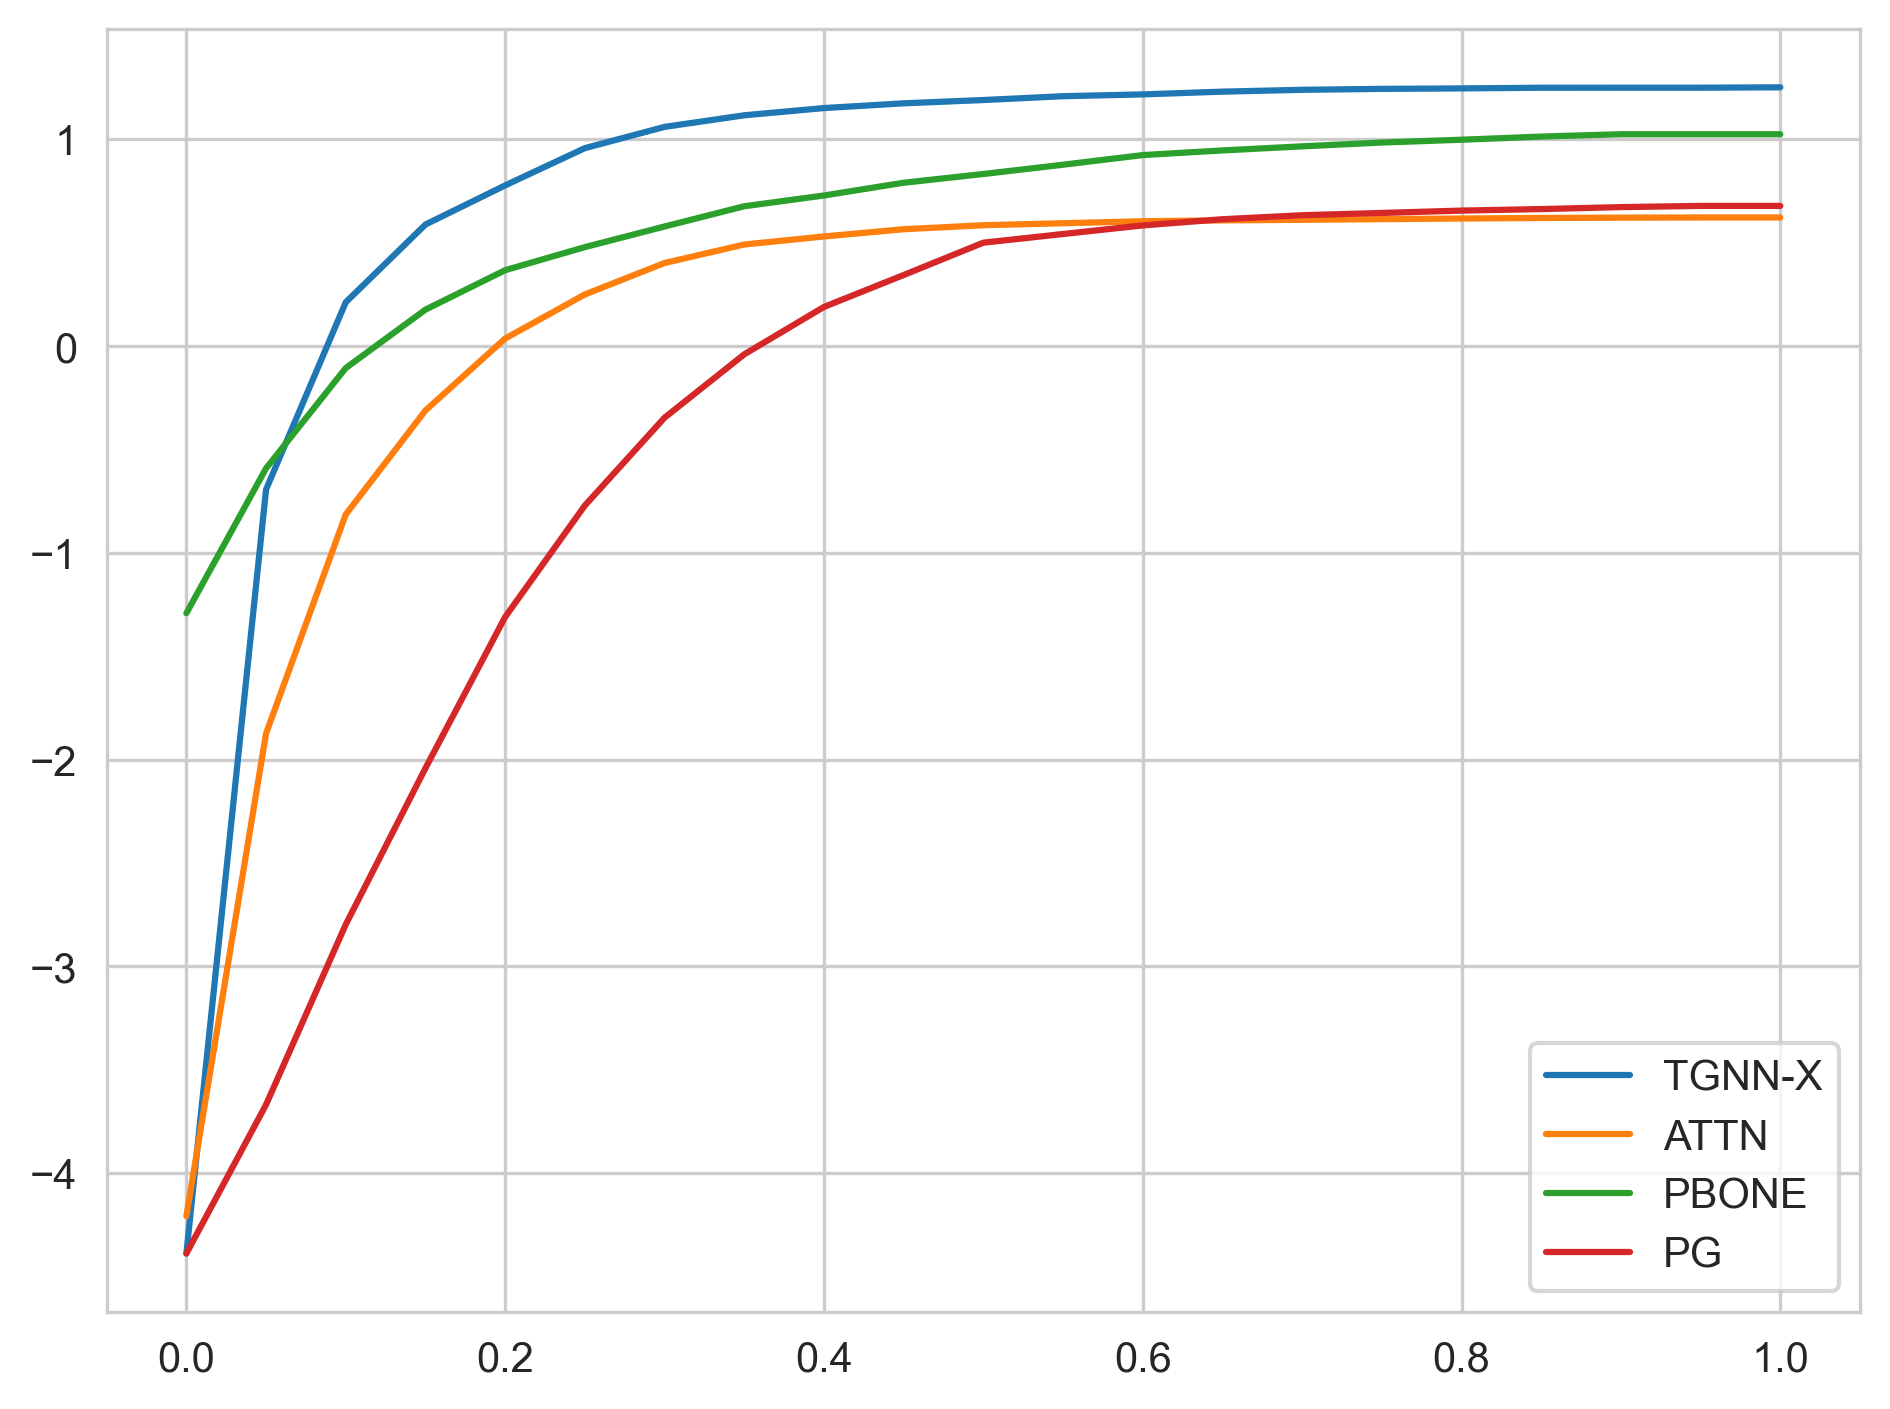

In [154]:
tgat_simulate_v1_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_simulate_v1_subgraphx_tg_3_to_15902_eval_pg_true_pg_positive.csv",
            "tgat_simulate_v1_attn_explainer_tg_3_to_15902_eval.csv",
            "tgat_simulate_v1_pbone_explainer_tg_3_to_15902_eval.csv",
            "tgat_simulate_v1_pg_explainer_tg_3_to_15902_eval.csv",
        ],
    )
}

tgat_simulate_v1_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgat_simulate_v1_files.items()
}

tgat_simulate_v1_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgat_simulate_v1_tabs.items()
}

tgat_simulate_v1_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgat_simulate_v1_tabs.items()
}
print("Best Fid:", tgat_simulate_v1_best_fids)
print("AUFSC:", tgat_simulate_v1_aufsc)

for k, tab in tgat_simulate_v1_tabs.items():
    print(
        f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
    )
    plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgat_simulate_v1.png")

## Simulate V2

Best Fid: {'xtg': 0.8340411904156209, 'attn': 0.05967254871129988, 'pbone': 0.7078214499056339, 'pg': 0.7464178370833396}
AUFSC: {'xtg': 0.6337536801677198, 'attn': -0.08515523201450705, 'pbone': 0.44202910242751237, 'pg': 0.22783191517032678}
xtg	 FID: 0.8340411904156209 	 AUC: 0.6337536801677198
attn	 FID: 0.05967254871129988 	 AUC: -0.08515523201450705
pbone	 FID: 0.7078214499056339 	 AUC: 0.44202910242751237
pg	 FID: 0.7464178370833396 	 AUC: 0.22783191517032678


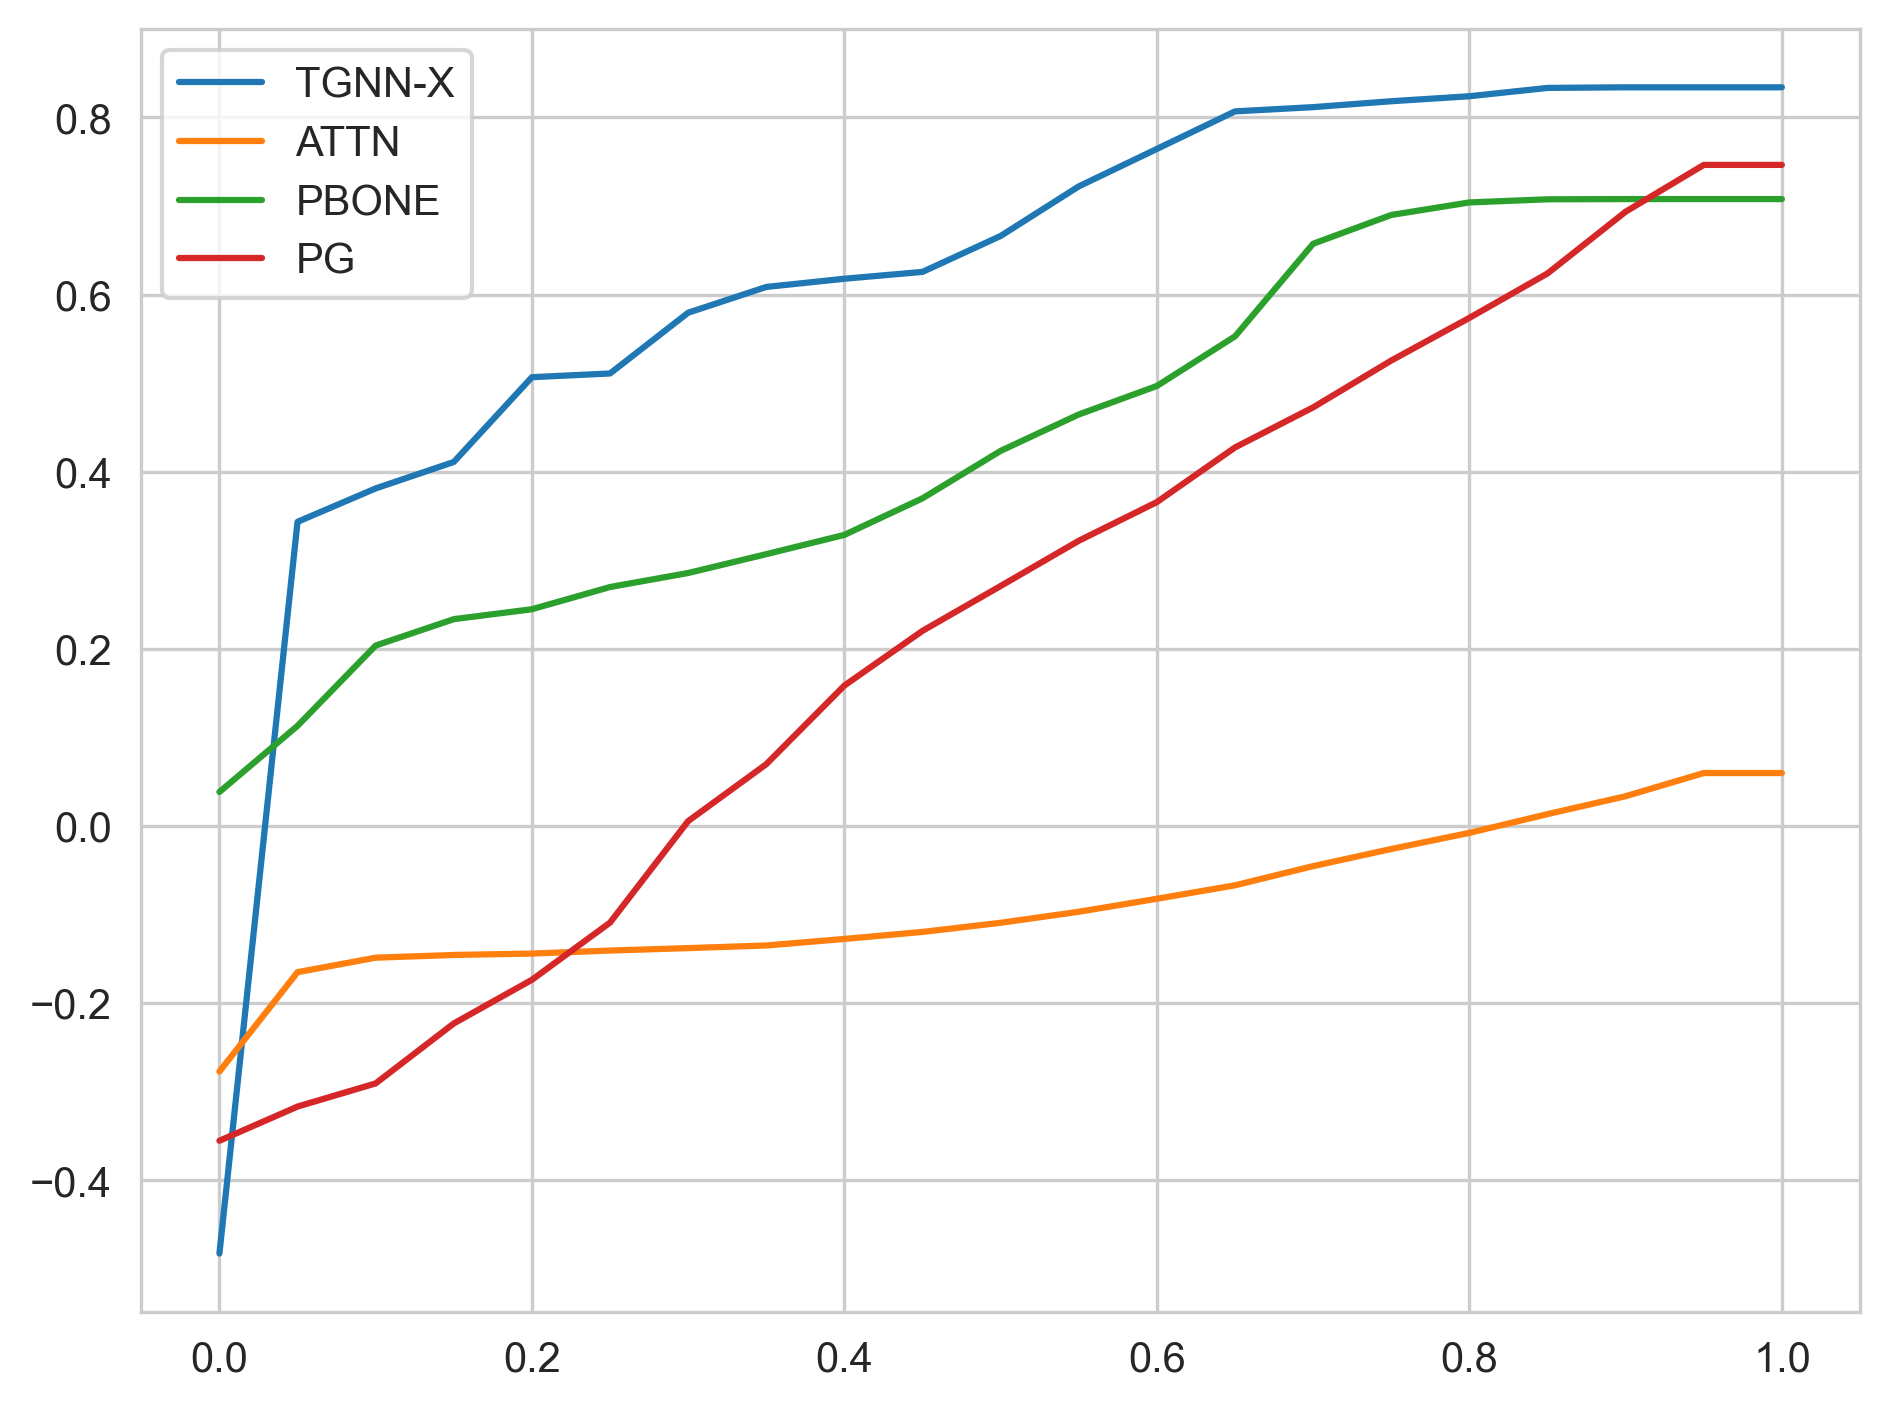

In [155]:
tgat_simulate_v2_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgat_simulate_v2_subgraphx_tg_3_to_21752_eval_pg_true_pg_positive.csv",
            "tgat_simulate_v2_attn_explainer_tg_3_to_21752_eval.csv",
            "tgat_simulate_v2_pbone_explainer_tg_3_to_21752_eval.csv",
            "tgat_simulate_v2_pg_explainer_tg_3_to_21752_eval.csv",
        ],
    )
}
tgat_simulate_v2_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgat_simulate_v2_files.items()
}
tgat_simulate_v2_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgat_simulate_v2_tabs.items()
}
tgat_simulate_v2_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgat_simulate_v2_tabs.items()
}
print("Best Fid:", tgat_simulate_v2_best_fids)
print("AUFSC:", tgat_simulate_v2_aufsc)

for k, tab in tgat_simulate_v2_tabs.items():
    print(
        f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
    )
    plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgat_simulate_v2.png")

# TGN
## Wikipedia

Best Fid: {'xtg': 0.8290388554781676, 'attn': 0.5148783878684043, 'pbone': 0.6475937870591879, 'pg': 0.45970433977246283}
AUFSC: {'xtg': 0.4439554229337722, 'attn': 0.3126810891754925, 'pbone': 0.3932880073327572, 'pg': -0.3673622658334673}
xtg	 FID: 0.8290388554781676 	 AUC: 0.4439554229337722
attn	 FID: 0.5148783878684043 	 AUC: 0.3126810891754925
pbone	 FID: 0.6475937870591879 	 AUC: 0.3932880073327572
pg	 FID: 0.45970433977246283 	 AUC: -0.3673622658334673


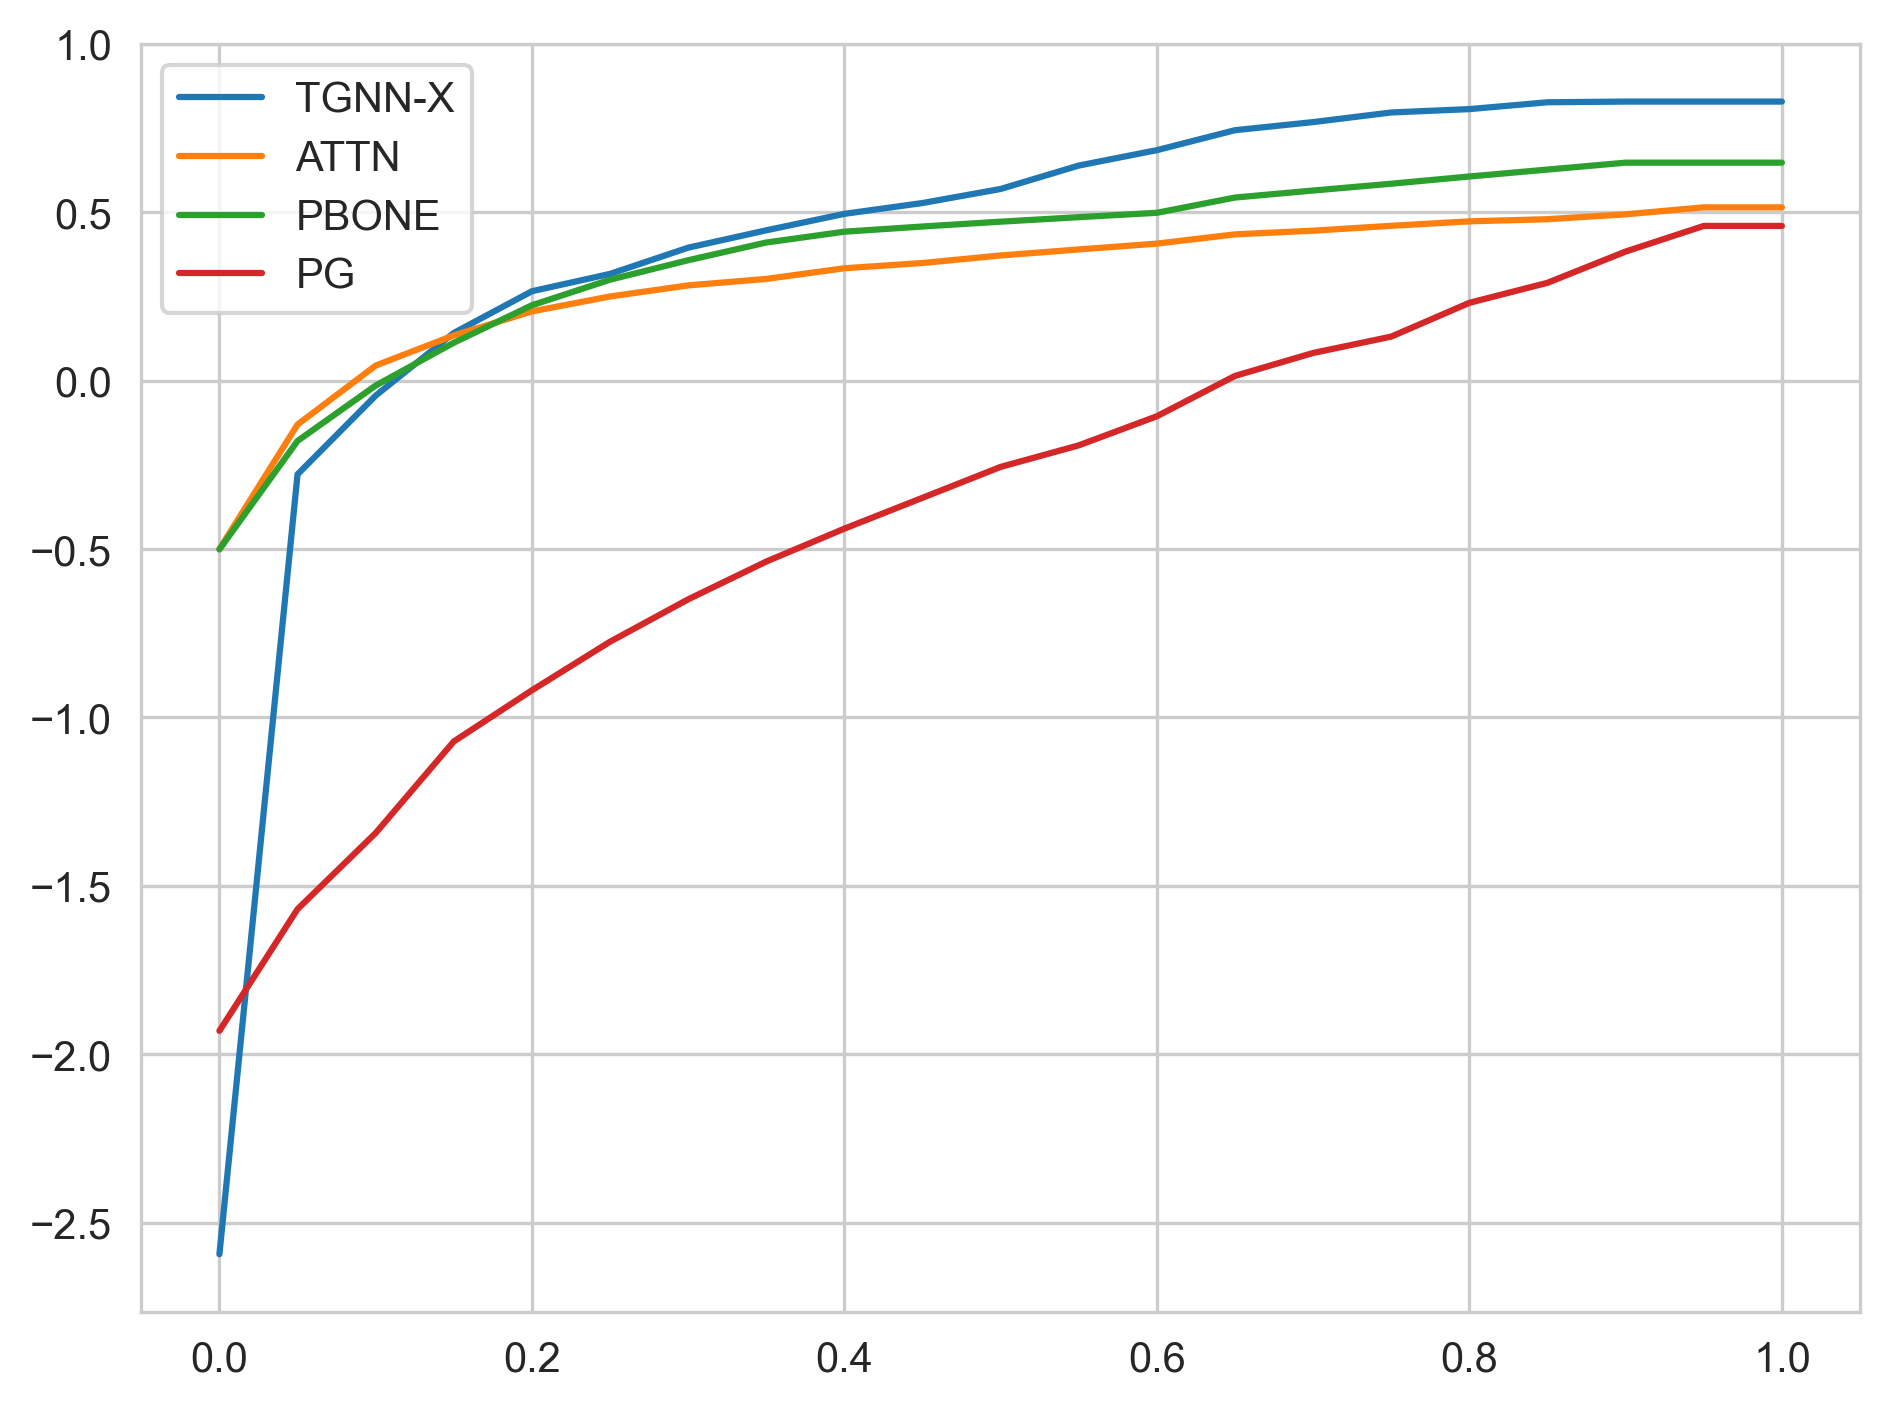

In [156]:
tgn_wikipedia_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_wikipedia_subgraphx_tg_110314_to_155614_eval_pg_true_pg_positive.csv",
            "tgn_wikipedia_attn_explainer_tg_110314_to_155614_eval.csv",
            "tgn_wikipedia_pbone_explainer_tg_110314_to_155614_eval.csv",
            "tgn_wikipedia_pg_explainer_tg_110314_to_155614_eval.csv",
        ],
    )
}

tgn_wikipedia_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgn_wikipedia_files.items()
}

tgn_wikipedia_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgn_wikipedia_tabs.items()
}
tgn_wikipedia_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index) for k, tab in tgn_wikipedia_tabs.items()
}
print("Best Fid:", tgn_wikipedia_best_fids)
print("AUFSC:", tgn_wikipedia_aufsc)

for k, tab in tgn_wikipedia_tabs.items():
    print(
        f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
    )
    plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgn_wikipedia.png")

## Reddit

Best Fid: {'xtg': 0.2385956601500511, 'attn': 0.14476382285356518, 'pbone': 0.24414053630828855, 'pg': 0.11693396629393099}
AUFSC: {'xtg': -1.492410185137764, 'attn': -1.5458064605053519, 'pbone': -0.6292809361521156, 'pg': -2.209208604266495}
xtg	 FID: 0.2385956601500511 	 AUC: -1.492410185137764
attn	 FID: 0.14476382285356518 	 AUC: -1.5458064605053519
pbone	 FID: 0.24414053630828855 	 AUC: -0.6292809361521156
pg	 FID: 0.11693396629393099 	 AUC: -2.209208604266495


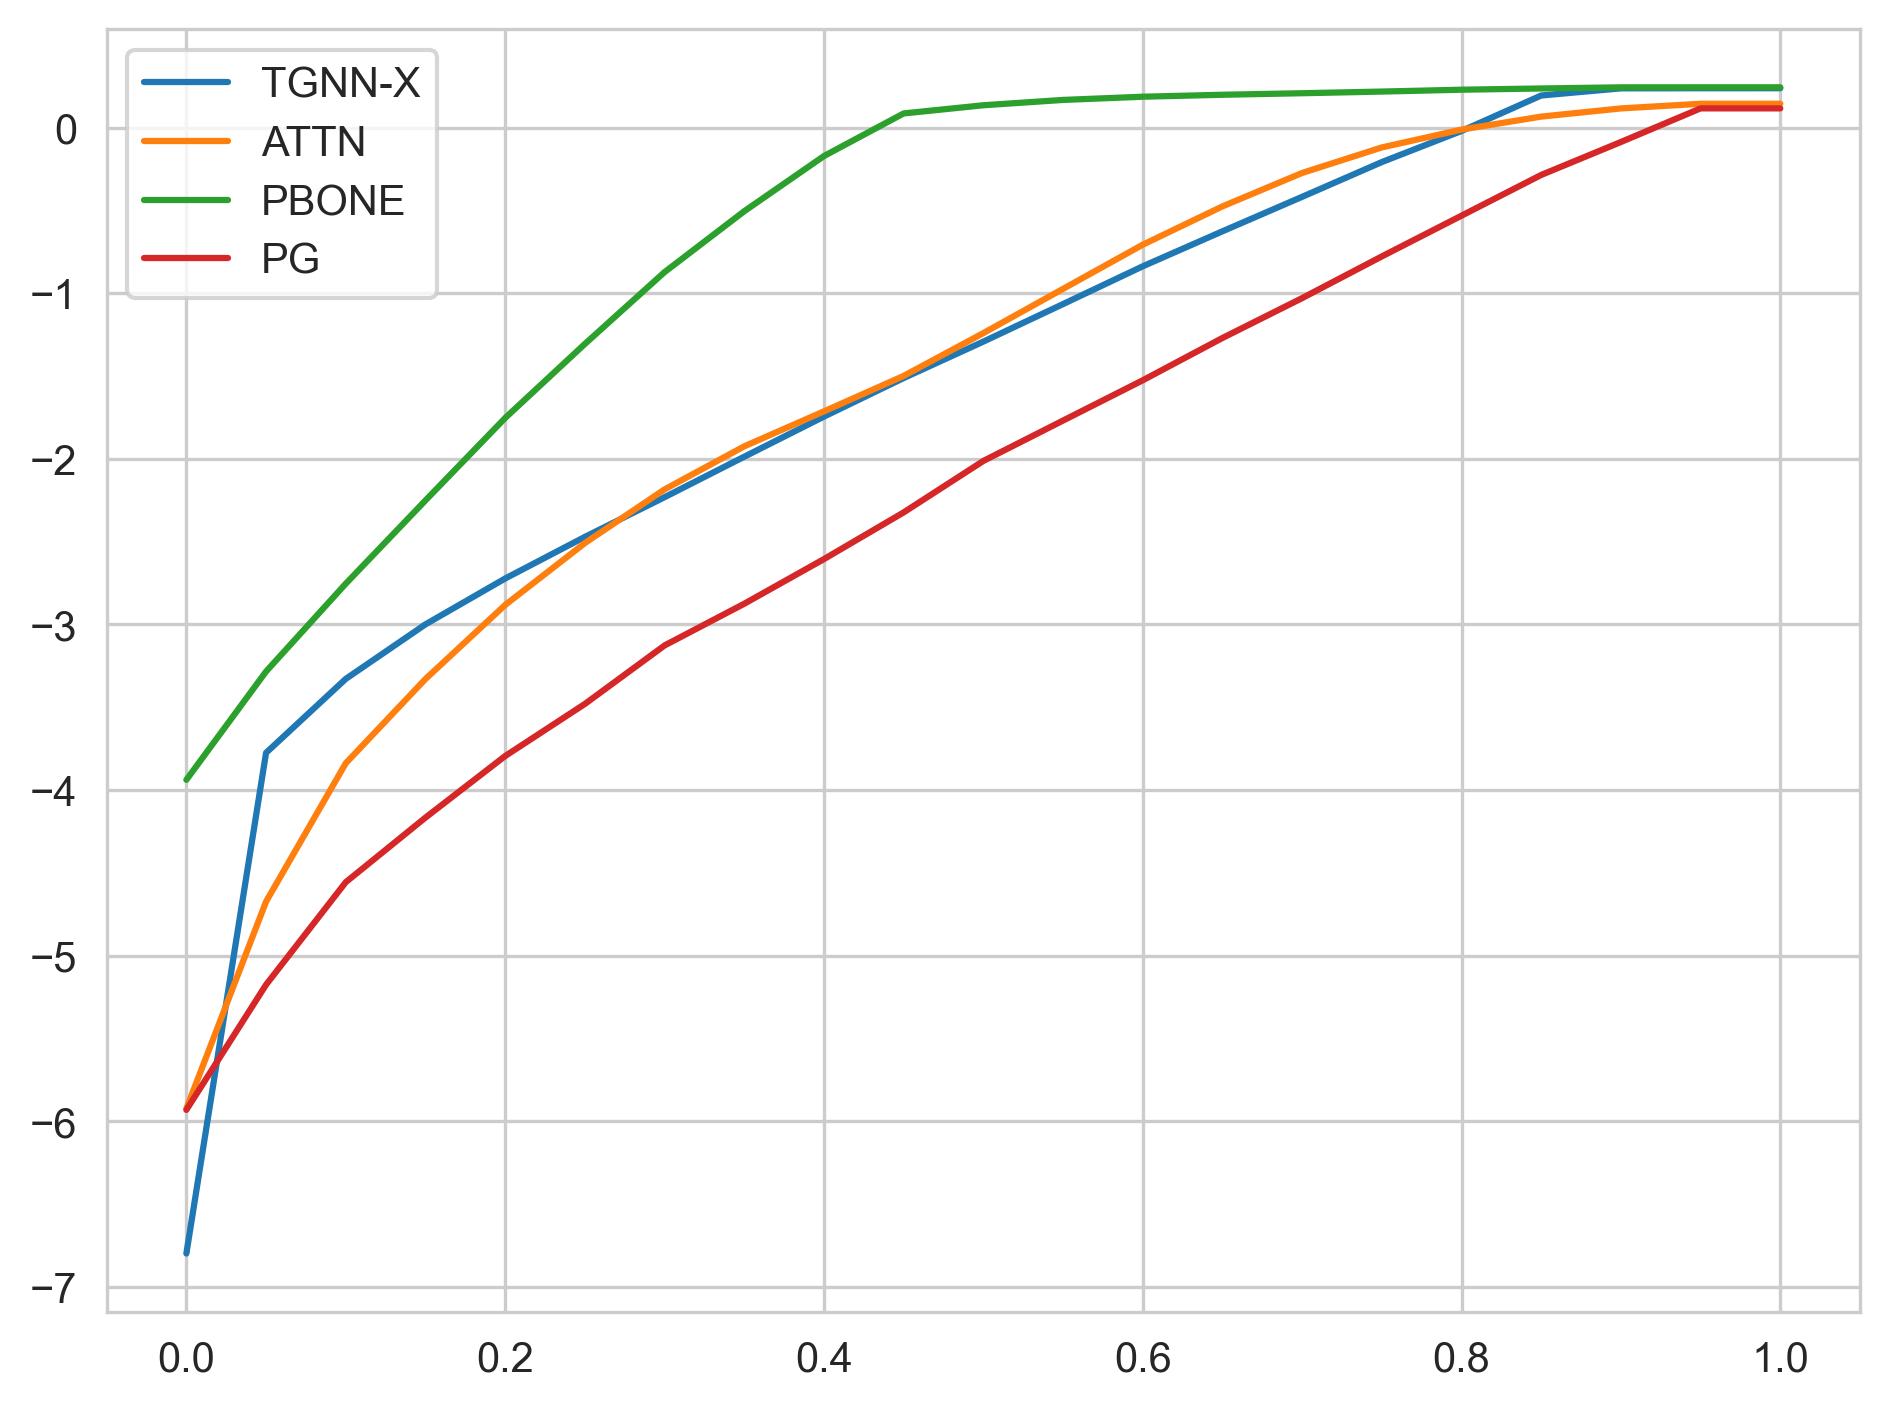

In [157]:
tgn_reddit_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_reddit_subgraphx_tg_470920_to_665351_eval_pg_true_pg_positive.csv",
            "tgn_reddit_attn_explainer_tg_470920_to_665351_eval.csv",
            "tgn_reddit_pbone_explainer_tg_470920_to_665351_eval.csv",
            "tgn_reddit_pg_explainer_tg_470920_to_665351_eval.csv",
        ],
    )
}

tgn_reddit_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean() for k, v in tgn_reddit_files.items()
}

tgn_reddit_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgn_reddit_tabs.items()
}

tgn_reddit_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index) for k, tab in tgn_reddit_tabs.items()
}

print("Best Fid:", tgn_reddit_best_fids)
print("AUFSC:", tgn_reddit_aufsc)

for k, tab in tgn_reddit_tabs.items():
    print(
        f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
    )
    plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgn_reddit.png")

## Simulate V1

Best Fid: {'xtg': 2.037055053472519, 'attn': 1.502154535293579, 'pbone': 1.814053654909134, 'pg': 1.4355251576900483}
AUFSC: {'xtg': 1.6109038057923317, 'attn': 0.8892634652346372, 'pbone': 0.8859449886798859, 'pg': 0.09209337216615679}
xtg	 FID: 2.037055053472519 	 AUC: 1.6109038057923317
attn	 FID: 1.502154535293579 	 AUC: 0.8892634652346372
pbone	 FID: 1.814053654909134 	 AUC: 0.8859449886798859
pg	 FID: 1.4355251576900483 	 AUC: 0.09209337216615679


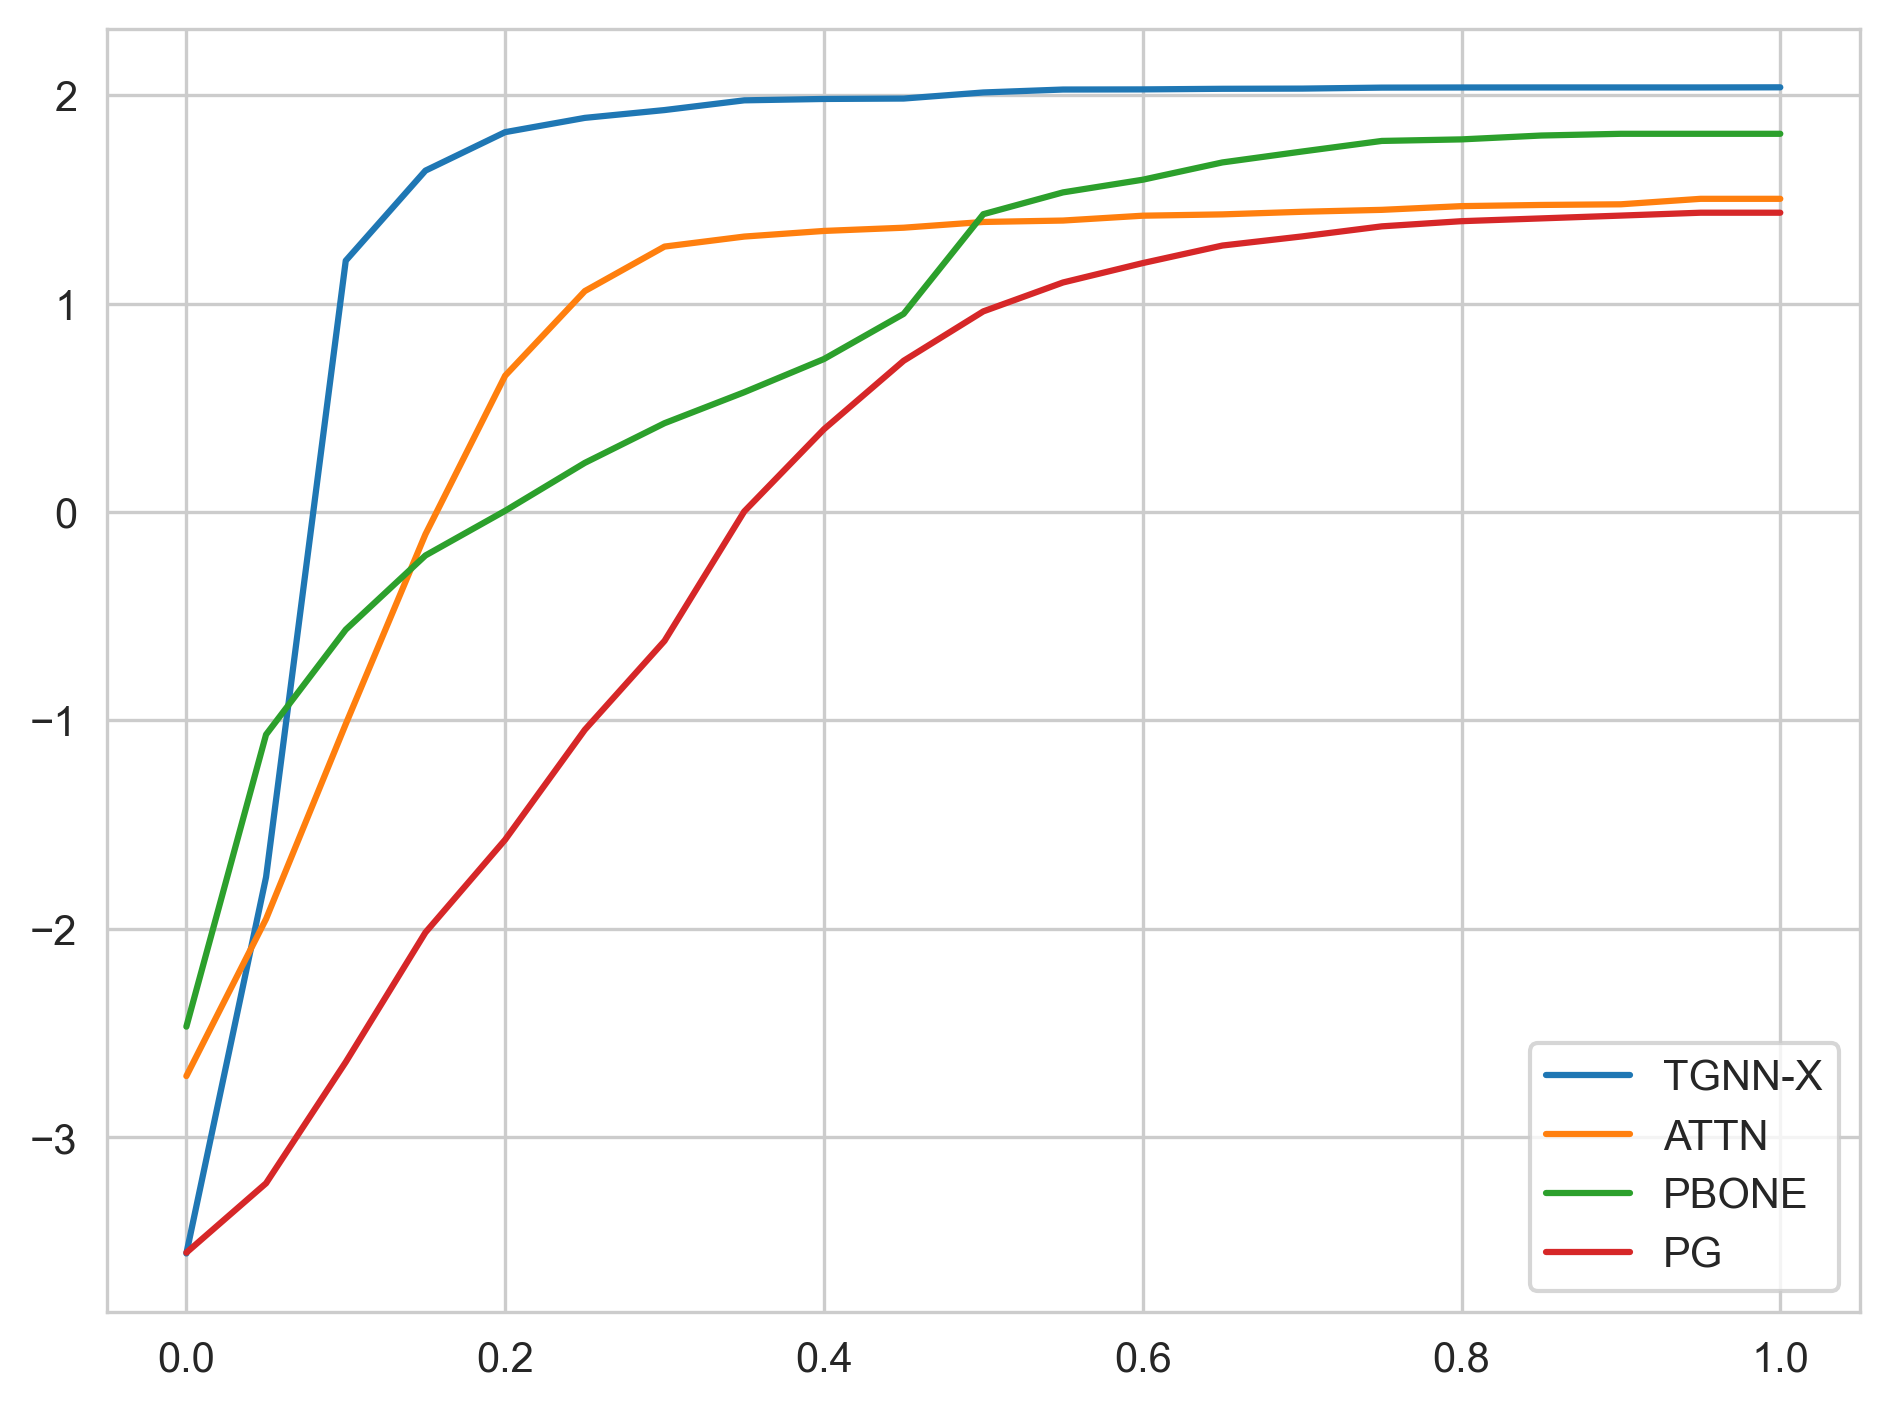

In [158]:
tgn_simulate_v1_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_simulate_v1_subgraphx_tg_3_to_15902_eval_pg_true_pg_positive.csv",
            "tgn_simulate_v1_attn_explainer_tg_3_to_15902_eval.csv",
            "tgn_simulate_v1_pbone_explainer_tg_3_to_15902_eval.csv",
            "tgn_simulate_v1_pg_explainer_tg_3_to_15902_eval.csv",
        ],
    )
}

tgn_simulate_v1_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgn_simulate_v1_files.items()
}

tgn_simulate_v1_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgn_simulate_v1_tabs.items()
}

tgn_simulate_v1_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgn_simulate_v1_tabs.items()
}
print("Best Fid:", tgn_simulate_v1_best_fids)
print("AUFSC:", tgn_simulate_v1_aufsc)

for k, tab in tgn_simulate_v1_tabs.items():
    print(
        f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
    )
    plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgn_simulate_v1.png")

## Simulate V2

Best Fid: {'xtg': 2.4425940346121786, 'attn': 1.659767407119274, 'pbone': 2.81320695155859, 'pg': 1.1117126109600066}
AUFSC: {'xtg': 0.8982748537071047, 'attn': -0.6773320452421904, 'pbone': -0.29036131019219763, 'pg': -1.903435571766645}
xtg	 FID: 2.4425940346121786 	 AUC: 0.8982748537071047
attn	 FID: 1.659767407119274 	 AUC: -0.6773320452421904
pbone	 FID: 2.81320695155859 	 AUC: -0.29036131019219763
pg	 FID: 1.1117126109600066 	 AUC: -1.903435571766645


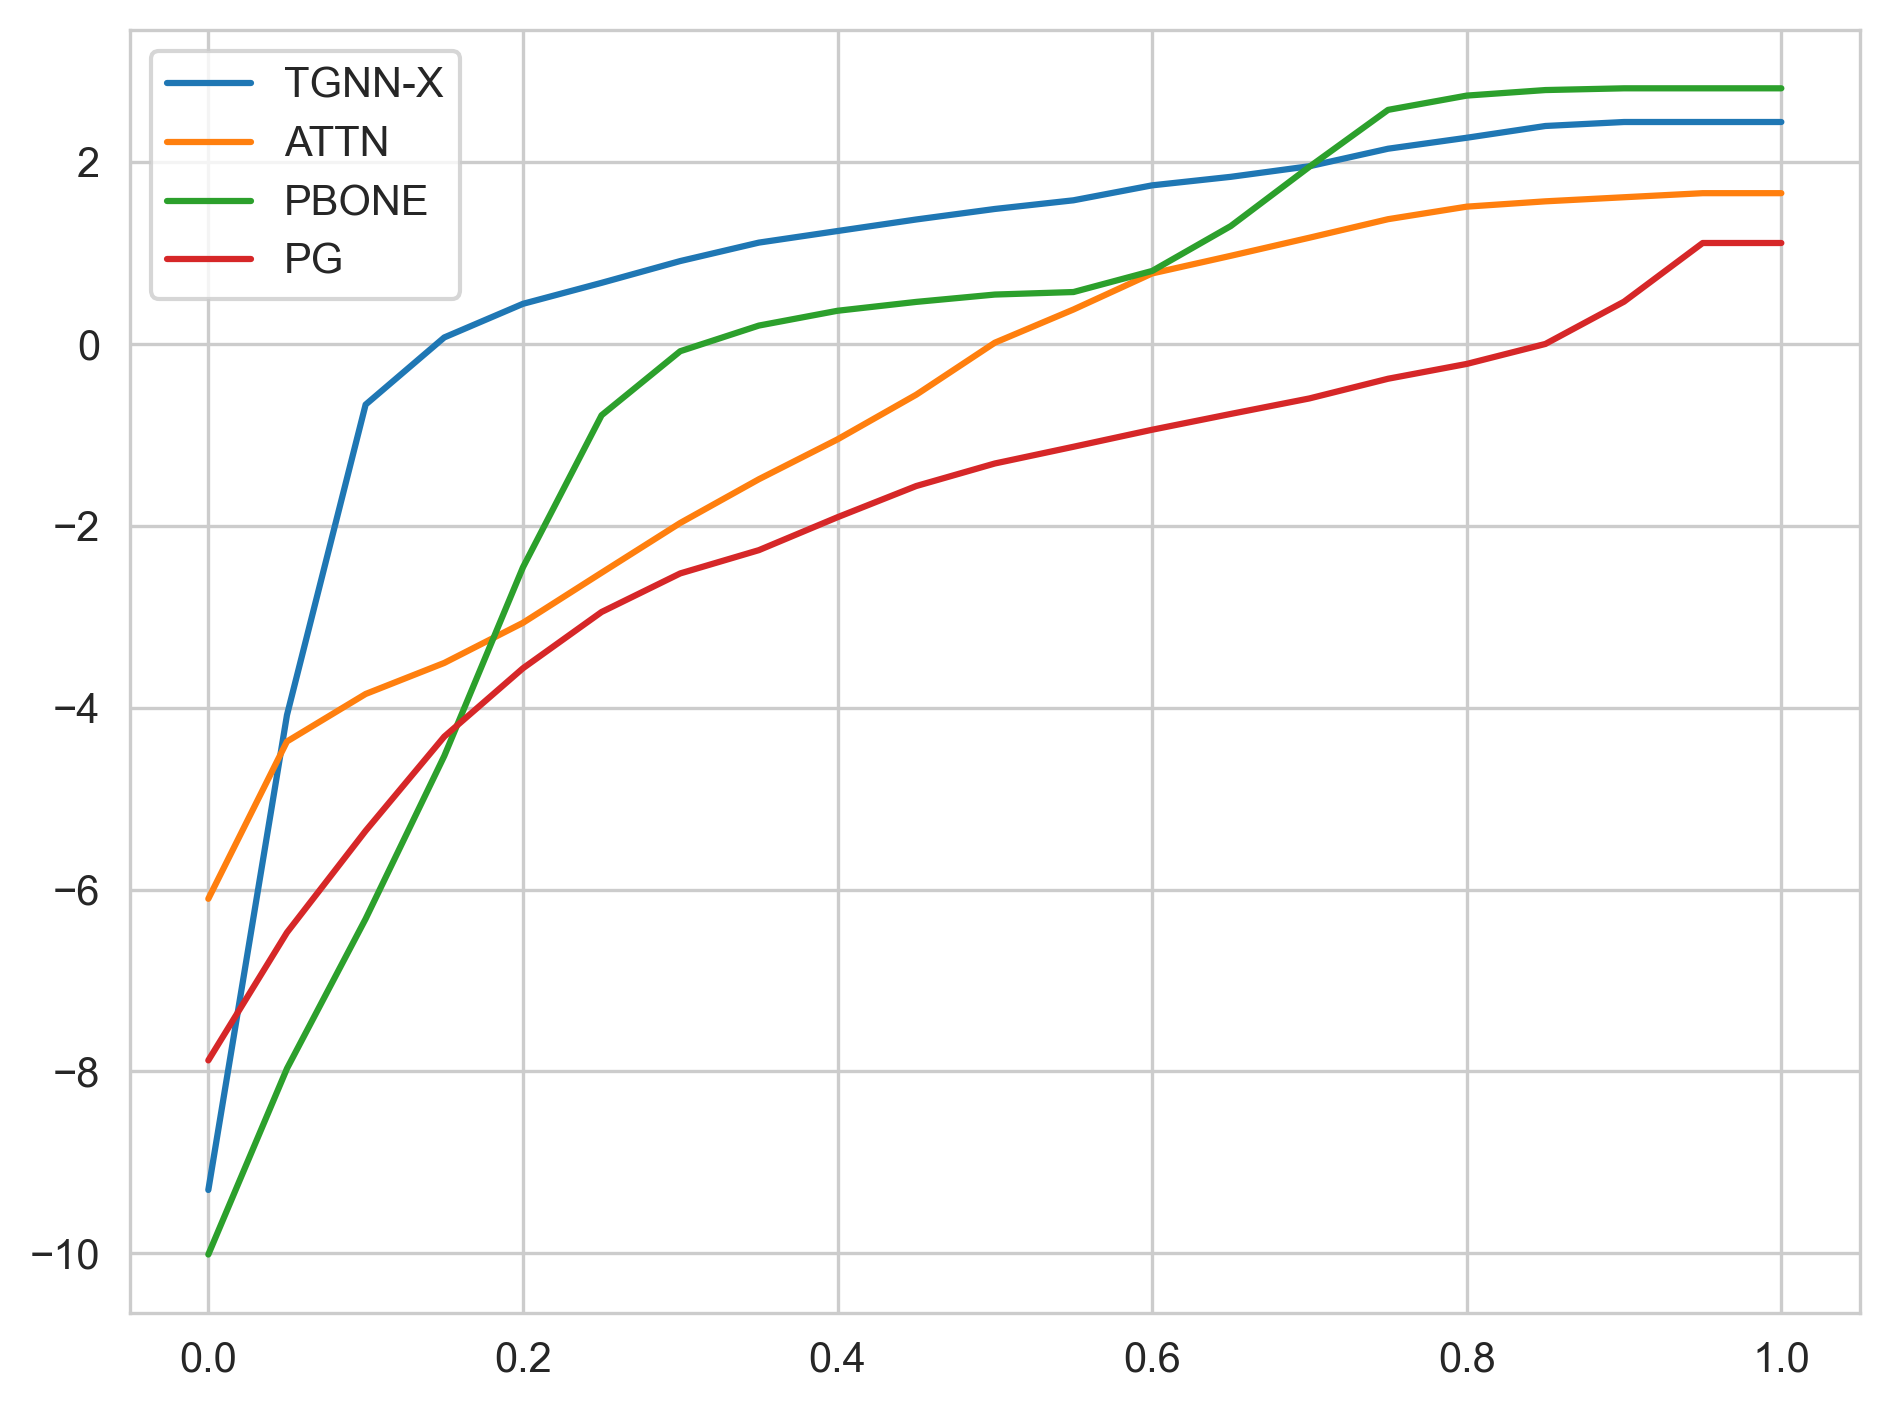

In [159]:
tgn_simulate_v2_files = {
    k: results_path / v
    for k, v in zip(
        explainers,
        [
            "tgn_simulate_v2_subgraphx_tg_3_to_21752_eval_pg_true_pg_positive.csv",
            "tgn_simulate_v2_attn_explainer_tg_3_to_21752_eval.csv",
            "tgn_simulate_v2_pbone_explainer_tg_3_to_21752_eval.csv",
            "tgn_simulate_v2_pg_explainer_tg_3_to_21752_eval.csv",
        ],
    )
}
tgn_simulate_v2_tabs = {
    k: pd.read_csv(v).groupby("sparsity").mean()
    for k, v in tgn_simulate_v2_files.items()
}
tgn_simulate_v2_best_fids = {
    k: tab["fid_inv_best"].max() for k, tab in tgn_simulate_v2_tabs.items()
}
tgn_simulate_v2_aufsc = {
    k: np.trapz(tab["fid_inv_best"], tab.index)
    for k, tab in tgn_simulate_v2_tabs.items()
}
print("Best Fid:", tgn_simulate_v2_best_fids)
print("AUFSC:", tgn_simulate_v2_aufsc)

for k, tab in tgn_simulate_v2_tabs.items():
    print(
        f"{k}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
    )
    plt.plot(tab.index, tab["fid_inv_best"], label=labels[k])
plt.legend();plt.tight_layout()
plt.savefig("plots/tgn_simulate_v2.png")

# Assemble everything
Here we assemble everything into a single dataframe and save it to a csv file.

In [160]:
datasets = ("wikipedia", "reddit", "simulate_v1", "simulate_v2")

model = "tgat"
locs = locals()
d1 = {
    f"{model}_{dataset}_best_fids": locs[f"{model}_{dataset}_best_fids"]
    for dataset in datasets
}
d2 = {
    f"{model}_{dataset}_aufsc": locs[f"{model}_{dataset}_aufsc"] for dataset in datasets
}

# zip the two in order to be side by side, my brain is fried i got no better suggestion
d = {}
for (k, v), (k2, v2) in zip(d1.items(), d2.items()):
    d[k] = v
    d[k2] = v2

df_tgat = pd.DataFrame.from_dict(d, orient="columns")

index = pd.MultiIndex(
    levels=[
        ["Wikipedia", "Reddit", "Simulate V1", "Simulate V2"],
        ["Best FID", "AUFSC"],
    ],
    codes=[
        [0, 0, 1, 1, 2, 2, 3, 3],
        [0, 1, 0, 1, 0, 1, 0, 1],
    ],
    names=["", ""],
)

df_tgat.columns = index
df_tgat.index = labels.values()
df_tgat = df_tgat.T[
    ["ATTN", "PBONE", "PG", "TGNN-X"]
].T  # reorder rows to correspond to their order

df_diff = (df_tgat - df_tgat_theirs) / df_tgat_theirs


datasets = ("wikipedia", "reddit", "simulate_v1", "simulate_v2")

model = "tgat"
# model = "tgn"

locs = locals()
d1 = {
    f"{model}_{dataset}_best_fids": locs[f"{model}_{dataset}_best_fids"]
    for dataset in datasets
}
d2 = {
    f"{model}_{dataset}_aufsc": locs[f"{model}_{dataset}_aufsc"] for dataset in datasets
}

# zip the two in order to be side by side, my brain is fried i got no better suggestion
d = {}
for (k, v), (k2, v2) in zip(d1.items(), d2.items()):
    d[k] = v
    d[k2] = v2

df_tgat = pd.DataFrame.from_dict(d, orient="columns")

index = pd.MultiIndex(
    levels=[
        ["Wikipedia", "Reddit", "Simulate V1", "Simulate V2"],
        ["Best FID", "AUFSC"],
    ],
    codes=[
        [0, 0, 1, 1, 2, 2, 3, 3],
        [0, 1, 0, 1, 0, 1, 0, 1],
    ],
    names=["", ""],
)

df_tgat.columns = index
df_tgat.index = labels.values()
df_tgat = df_tgat.T[
    ["ATTN", "PBONE", "PG", "TGNN-X"]
].T  # reorder rows to correspond to their order in OG paper

import matplotlib.colors as mcolors


def color_gradient(val, cmap="coolwarm", vmin=None, vmax=None):
    """
    Takes a scalar and returns a string with
    the css property `'color: ...'` for a color
    based on the value relative to the vmin and vmax.
    """
    cmap = plt.get_cmap(cmap)
    norm = mcolors.AsinhNorm(vmin=vmin, vmax=vmax)
    color = mcolors.rgb2hex(cmap(norm(val)))
    return f" color: {color}({val})"


# df_latex = df_tgat.applymap(lambda x: f"{x:.2f}") + (df_tgat - df_tgat_theirs).applymap(lambda x: f" ({x:.1f})")
# display(df_latex)

df_latex = df_tgat
df_latex = df_latex.style.format(precision=3).to_latex(
    convert_css=True,
    multicol_align="c",
    hrules=True,
    position_float="centering",
    column_format="lcccccccc",
)

# put caption at the end
df_latex = df_latex.replace(
    "\\end{tabular}",
    f"\\end{{tabular}}\n\\caption{{\\label{{tab:{model}_results}}Explainer results for {model.upper()} model.}}",
)

df_diff = (df_tgat - locs[f"df_{model}_theirs"]) / locs[f"df_{model}_theirs"] * 100
df_diff = (
    df_diff.style.format(precision=3)
    .to_latex(
        convert_css=True,
        multicol_align="c",
        hrules=True,
        position_float="centering",
        column_format="lrrrrrrrr",
    )
    .replace(
        "\\end{tabular}",
        f"\\end{{tabular}}\n\\caption{{\\label{{tab:{model}_results_diff}}Relative difference in results for {model.upper()} model with respect to the original paper (in \\%).}}",
    )
)
with open(f"{model}_results_tab.tex", "w") as f:
    f.write(df_latex)

with open(f"{model}_results_diff_tab.tex", "w") as f:
    f.write(df_diff)

with open(f"{model}_results_og_tab.tex", "w") as f:
    f.write(
        locs[f"df_{model}_theirs"].style.format(precision=3).to_latex(
            multicol_align="c",
            hrules=True,
            clines="skip-last;data",
            position_float="centering",
            column_format="lcccccccc",
        ).replace(
            "\\end{tabular}",
            f"\\end{{tabular}}\n\\caption{{\\label{{tab:{model}_results_og}}Results for {model.upper()} model from the original paper.}}"))

# set display precision
print(df_latex)

\begin{table}
\centering
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{2}{c}{Wikipedia} & \multicolumn{2}{c}{Reddit} & \multicolumn{2}{c}{Simulate V1} & \multicolumn{2}{c}{Simulate V2} \\
 & Best FID & AUFSC & Best FID & AUFSC & Best FID & AUFSC & Best FID & AUFSC \\
\midrule
ATTN & 0.812 & 0.514 & 0.466 & -0.936 & 0.622 & 0.179 & 0.060 & -0.085 \\
PBONE & 1.260 & 0.869 & 1.212 & 0.817 & 1.024 & 0.628 & 0.708 & 0.442 \\
PG & 0.685 & -0.375 & 0.548 & -0.829 & 0.678 & -0.306 & 0.746 & 0.228 \\
TGNN-X & 1.412 & 0.914 & 1.189 & 0.421 & 1.251 & 0.855 & 0.834 & 0.634 \\
\bottomrule
\end{tabular}
\caption{\label{tab:tgat_results}Explainer results for TGAT model.}
\end{table}



# Decision Explanation

In [161]:
mcts_node_info = sorted(mcts_path.glob("*simulate_v1_73*"))[-1]
node_info = torch.load(mcts_node_info)
node_info = node_info["saved_MCTSInfo_list"]  # there is only one key in the dict
node_info[0], node_info[-1]

({'coalition': [7327, 7330, 7334, 7335, 7336, 7339, 7344, 7346],
  'created_by_remove': 7331,
  'c_puct': 100,
  'W': 4.0906665325164795,
  'N': 2,
  'P': -10.874029278755188,
  'Sparsity': 0.4},
 {'coalition': [7327, 7330, 7331, 7334, 7335, 7339, 7344, 7345],
  'created_by_remove': 7340,
  'c_puct': 100,
  'W': 16.362666130065918,
  'N': 8,
  'P': 2.9116233587265015,
  'Sparsity': 0.4})

# Runtime comparison

In [162]:
# seconds
training_runtimes = {
    # simulate_v1, simulate_v2, wikipedia, reddit
    "TGAT": [5.0, 6.1, 93, 627.23],
    "TGN": [18.1, 4.2, 84.7, 614],
}


candidate_scores_path = results_path / "candidate_scores"
scores = {}
not_found = []
for model in ["tgat", "tgn"]:
    scores[model] = {}
    for dataset in ["simulate_v1", "simulate_v2", "wikipedia", "reddit"]:
        try:
            scores[model][dataset] = pd.read_csv(
                next(candidate_scores_path.glob(f"*{model}_{dataset}*"))
            )["runtime"].mean()
        except (KeyError, StopIteration):
            not_found.append(f"{model}_{dataset}")
            continue

print("Not found:", not_found)

# explain_runtimes = {"TGAT": scores, "TGN": {"Reddit": []}}
scores
# df = pandas.DataFrame.from_dict(dictionary, orient="index").stack().to_frame()
# # to break out the lists into columns
# df = pandas.DataFrame(df[0].values.tolist(), index=df.index)

Not found: ['tgat_simulate_v1', 'tgat_simulate_v2', 'tgat_wikipedia', 'tgn_simulate_v2']


{'tgat': {'reddit': 35.23480161523819},
 'tgn': {'simulate_v1': 13.749175183296204,
  'wikipedia': 0.0181739330291748,
  'reddit': 77.00699723005295}}

In [12]:
import pstats
stats = pstats.Stats('./profile.txt')
stats.sort_stats(pstats.SortKey.TIME).print_stats(100)

Tue Jan 30 16:50:55 2024    ./profile.txt

         110075325 function calls (107973736 primitive calls) in 237.448 seconds

   Ordered by: internal time
   List reduced from 14489 to 100 due to restriction <100>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   668675   22.799    0.000   58.212    0.000 /Users/Matey/miniconda3/lib/python3.11/site-packages/numpy/lib/arraysetops.py:524(in1d)
88647/29549   19.867    0.000  127.829    0.004 /Users/matey/project/fact8/tgnnexplainer/xgraph/models/ext/tgn/modules/embedding_module.py:170(compute_embedding)
   561511   15.102    0.000   15.102    0.000 {built-in method torch._C._nn.linear}
   975519   14.462    0.000   14.647    0.000 /Users/matey/project/fact8/tgnnexplainer/xgraph/models/ext/tgat/graph.py:55(find_before)
  3030485    9.990    0.000    9.990    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    29549    7.418    0.000  137.904    0.005 /Users/matey/project/fact8/tgnnexplainer/xgraph/models/ext/tgn/m